# LightGBM Baseline Model

make models for each route(A, B, C, D) and prediction period(predict 2 weeks ahead, 4 weeks ahead, ...)

## Dateset
- [diff value from previous day](https://github.com/hiroshi-kuriyama/rail_level_gap/issues/2) of [rolling mean over days](https://github.com/hiroshi-kuriyama/rail_level_gap/issues/4)
## Target Variable
- vel_l values X weeks ahead (X = 2,4,6,8)
## Features

- track variables
  - present lev_l value
  - mean and variance of recent lev_l value
  - mean and variance of recent days and whole year values of track data
- equipment variables
  - row value of equipment variables
- seasonal variables
  - date (encoded by trigonometric function)
  - holiday dummy

In [45]:
import os
import pickle
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from hyperopt import hp, tpe, Trials, fmin
%matplotlib inline
# from utils import data_process as dp

In [46]:
input_dir = '../input/'
working_dir = '../working/'
output_dir = '../output/'

## Read data

In [47]:
sleeper_type_dict = {
    1: 'pc',
    2: 'wooden',
    3: 'junction',
    4: 'short',
    5: 'synthetic',
    6: 'synth_junc',
    7: 'symth_short',
    8: 'other'
}

In [48]:
def read_track(line_name='a'):
    track_df = pd.read_csv(os.path.join(input_dir, 'track_{}.csv'.format(line_name.upper())))
    col_names_track = ['date', 'kilo', 'lev_l', 'lev_r', 'cur_l', 'cur_r', 'cant', 'width', 'speed']
    track_df.columns = col_names_track
    track_df['date'] = pd.to_datetime(track_df['date'])
    track_df['kilo'] = track_df['kilo'].astype('str')
    print('track_{line_name} shape: {shape}'.format(line_name=line_name.upper(), shape=track_df.shape))
    return track_df

In [49]:
def read_equ(line_name='a'):
    equ_df = pd.read_csv(os.path.join(input_dir, 'equipment_{}.csv'.format(line_name.upper())))
    col_names_equ = ['kilo', 'is_ballast', 'is_long', 'sleeper_type', 'is_bridge', 'is_crossing', 'gross_ton', 'radius', 'is_unreliable']
    equ_df.columns = col_names_equ
    equ_df['kilo'] = equ_df['kilo'].astype('str')
    equ_df['sleeper_type'] = equ_df['sleeper_type'].replace(sleeper_type_dict).astype('category')
    print('equ_{line_name} shape: {shape}'.format(line_name=line_name.upper(), shape=equ_df.shape))
    return equ_df

In [50]:
# degrade data types to save memory
def degrade_dtypes(df):
    for col in df.columns:
        if df[col].dtype=='int64':
            df[col] = df[col].astype('int32')
        if df[col].dtype=='float64':
            df[col] = df[col].astype('float32')
    return df

In [51]:
abcd = 'a'

In [52]:
track = read_track(abcd)
track = degrade_dtypes(track)
equ = read_equ(abcd)
equ = degrade_dtypes(equ)

track_A shape: (10185690, 9)
equ_A shape: (27906, 9)


In [53]:
sample_submit = pd.read_csv(os.path.join(input_dir, 'sample_submit.csv'), header=None)
index_master = pd.read_csv(os.path.join(input_dir, 'index_master.csv'))
index_master.columns = ['id', 'line_name', 'date', 'kilo']
index_master['date'] = pd.to_datetime(index_master['date'])
index_master['kilo'] = index_master['kilo'].astype('str')

## Data Processing
### rolling average, diff

In [54]:
# rolling average params
roll_params = {
    'A': {'window': 21, 'min_periods': 14},
    'B': {'window': 14, 'min_periods': 7},
    'C': {'window': 14, 'min_periods': 7},
    'D': {'window': 14, 'min_periods': 7}
}

In [55]:
def roll_diff(track, abcd):
        # pivot: row is date, col is kilo
        lev_pv = track.pivot(index='date', columns='kilo', values='lev_l')
        lev_pv.columns = lev_pv.columns.astype('str')
        # rolling average
        lev_pv_ra = lev_pv.rolling(**roll_params[abcd.upper()], center=True, axis=0).mean()
        # diff
        lev_pv_ra_diff = lev_pv_ra.diff()
        # reverse pivot
        lev_ra_diff = pd.melt(lev_pv_ra_diff.reset_index(), id_vars='date', value_name='lev_l_diff')  
        return lev_ra_diff, lev_pv_ra

In [56]:
lev_ra_diff, lev_pv_ra = roll_diff(track, abcd)

## Target variable

In [57]:
def make_tgt(lev_ra_diff):
    lev_ra_diff_tgt_tmp = lev_ra_diff.copy()
    lev_ra_diff_tgt_tmp['date_tgt'] = lev_ra_diff_tgt_tmp['date']
    lev_ra_diff_tgt_tmp['date'] = lev_ra_diff_tgt_tmp['date'] - datetime.timedelta(weeks=2)
    lev_ra_diff_tgt = lev_ra_diff_tgt_tmp.rename(columns={'lev_l_diff': 'lev_l_diff_tgt'})
    return lev_ra_diff_tgt

In [58]:
lev_ra_diff_tgt = make_tgt(lev_ra_diff)

## Feature processing

In [59]:
def whole_mean(track):
    track_whole_mean = track.groupby('kilo').mean()
    track_whole_mean.columns = [i + '_w_mean' for i in track_whole_mean.columns]
    track_whole_mean = track_whole_mean.reset_index()
    track_whole_mean['kilo'] = track_whole_mean['kilo'].astype(str)
    return track_whole_mean

In [60]:
def whole_std(track):
    track_whole_mean = track.groupby('kilo').std()
    track_whole_mean.columns = [i + '_w_std' for i in track_whole_mean.columns]
    track_whole_mean = track_whole_mean.reset_index()
    track_whole_mean['kilo'] = track_whole_mean['kilo'].astype(str)
    return track_whole_mean

In [61]:
track_whole_std = whole_std(track)
track_whole_mean = whole_mean(track)

## Merge Dataset

In [62]:
def merge_features_by_kilo(df):
    df = df.merge(track_whole_mean, on='kilo')
    df = df.merge(track_whole_std, on='kilo')
    df = df.merge(equ, on='kilo')
    return df

In [63]:
# copy target df
data_all_tmp = lev_ra_diff_tgt.copy()
# merge features
data_all_tmp = data_all_tmp.merge(lev_ra_diff, on=['date', 'kilo'])
data_all_tmp = merge_features_by_kilo(data_all_tmp)

data_all_tmp = data_all_tmp.dropna(how='any', axis=0, subset=['lev_l_diff_tgt', 'lev_l_diff'])

data_all = data_all_tmp
    
# del lev_ra_diff_tgt, lev_ra_diff, track_whole_mean, data_all_tmp, track, equ

## Make Dataset

In [64]:
def X_y_split(data, tgt_col='lev_l_diff_tgt', index_cols=['date', 'date_tgt', 'kilo']):
    data = data.set_index(index_cols)
    y = data[tgt_col]
    X = data.drop(tgt_col, axis=1)
    return X, y

In [65]:
# split train and test
threshold_date = '2018-01-01'
X_dev, y_dev = X_y_split(data_all.query('date<"{}"'.format(threshold_date)))
X_val, y_val = X_y_split(data_all.query('date>"{}"'.format(threshold_date)))

## Train

In [66]:
hyperopt_params = {
    'bagging_freq': hp.uniform('bagging_freq', 0, 1),
    'feature_fraction': hp.uniform('feature_fraction', 0.1, 0.3),
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.3),
    'min_child_samples': hp.uniform('min_child_samples', 400, 600),
    'num_leaves': hp.uniform('num_leaves', 500, 700),
}

In [67]:
fit_params = {
    'early_stopping_rounds':20,
    'eval_set':[(X_val, y_val)],
    'eval_metric': 'mean_absolute_error',
    'verbose': False
}

In [68]:
# float to int
tobe_int_params = ['num_leaves', 'min_child_samples', 'bagging_freq']
def int_param_encoder(params):
    for param in tobe_int_params:
        if param in params:
            params[param] = int(params[param])
    return params

In [69]:
num_evals_i = 0
def objective(hyperopt_params):
    # パラメータを適切な型(int)に変換
    hyperopt_params = int_param_encoder(hyperopt_params)
    # モデルのインスタンス化
    model = lgb.LGBMRegressor(**hyperopt_params, objective='mean_absolute_error', n_estimators=1000, random_state=0)
    # trainデータを使ってモデルの学習
    model.fit(X_dev, y_dev, **fit_params)
    # validationデータを使用して、ラベルの予測
    y_val_pred = model.predict(X_val, num_iteration=model.best_iteration_)
    # 予測ラベルと正解ラベルを使用してMAEを計算
    mae_score = mean_absolute_error(y_val, y_val_pred)
    global num_evals_i
    num_evals_i += 1
    print('[{num_evals}] best_ite: {best_ite}\tMAE: {mae_score}'.format(num_evals=str(num_evals_i).zfill(4), mae_score=mae_score, best_ite=model.best_iteration_))
    return mae_score

In [70]:
# iterationする回数
max_evals = 10
# 試行の過程を記録するインスタンス
trials = Trials()

best = fmin(
    # 最小化する値を定義した関数
    fn=objective,
    # 探索するパラメータのdictもしくはlist
    space=hyperopt_params,
    # どのロジックを利用するか、基本的にはtpe.suggestでok
    algo=tpe.suggest,
    max_evals=max_evals,
    trials=trials,
    # 試行の過程を出力
    verbose=-1,
    rstate=np.random.RandomState(0)
)

[0001] best_ite: 117	MAE: 0.020148843015505624
[0002] best_ite: 125	MAE: 0.02016976123937936
[0003] best_ite: 95	MAE: 0.020172588052614737
[0004] best_ite: 220	MAE: 0.02015484422317537
[0005] best_ite: 1	MAE: 0.020303825621544574
[0006] best_ite: 143	MAE: 0.020154803244114654
[0007] best_ite: 84	MAE: 0.020173035638702184
[0008] best_ite: 67	MAE: 0.02020895349713239
[0009] best_ite: 23	MAE: 0.020284945472977114
[0010] best_ite: 76	MAE: 0.020184606928624137


In [71]:
int_param_encoder(best)

{'bagging_freq': 0,
 'feature_fraction': 0.1391192820324445,
 'learning_rate': 0.2963940126653997,
 'min_child_samples': 537,
 'num_leaves': 597}

In [72]:
best_params = int_param_encoder(best)
model = lgb.LGBMRegressor(**best_params, objective='mean_absolute_error', n_estimators=1000, random_state=0)
model.fit(X_dev, y_dev, **fit_params)

LGBMRegressor(bagging_freq=0, boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, feature_fraction=0.1391192820324445,
       importance_type='split', learning_rate=0.2963940126653997,
       max_depth=-1, min_child_samples=537, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=1000, n_jobs=-1, num_leaves=597,
       objective='mean_absolute_error', random_state=0, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

In [73]:
with open(os.path.join(output_dir, 'lgbm_baseline_20181120_model_{}.pkl'.format(abcd.upper())), mode='wb') as f:
    pickle.dump(model, f)
    
# with open(os.path.join(output_dir, 'lgbm_baseline_20181120_model_{}.pkl'.format(abcd.upper())), mode='rb') as f:
#     model = pickle.load(f)

## Predict for Submission
1. make initial values using last date lev_l_diff of each kilo
2. predict 2 weeks ahead lev_l values by the initial values
3. predcit 4 weeks ahead lev_l values by the 2 weeks ahead lev_l values
4. repeat ...

### make initial values for future prediction

In [74]:
last_date_lev_ra_diff_index = lev_ra_diff.dropna(subset=['lev_l_diff'])
last_date_lev_ra_diff_index = last_date_lev_ra_diff_index.groupby('kilo')['date'].max()
last_date_lev_ra_diff_index = last_date_lev_ra_diff_index.reset_index()

In [75]:
# make index having latest date of each kilo
# if the kilo has no value through all the period, fill them by NULL
def make_last_date_lev_ra_diff_index(lev_ra_diff):
    # latest date values of each kilo
    last_date_lev_ra_diff_index = lev_ra_diff.dropna(subset=['lev_l_diff'])
    last_date_lev_ra_diff_index = last_date_lev_ra_diff_index.groupby('kilo')['date'].max()
    last_date_lev_ra_diff_index = last_date_lev_ra_diff_index.reset_index()
    # make full_kilo index to fill missing kilo by NUll
    kilo_index_tmp = lev_ra_diff.groupby('kilo')['kilo'].count().rename('tmp')
    kilo_index_tmp = kilo_index_tmp.reset_index()
    # join to full_kilo index
    last_date_lev_ra_diff_index = kilo_index_tmp.merge(last_date_lev_ra_diff_index, on='kilo', how='left')
    # drop un
    last_date_lev_ra_diff_index = last_date_lev_ra_diff_index.drop('tmp', axis=1)
    return last_date_lev_ra_diff_index

# maek initial 'lev_l_diff' values of each kilo
# The values are from the lastest date values of each kilo
def make_last_date_lev_ra_diff(lev_ra_diff, last_date_lev_ra_diff_index):
    # merge values into index
    last_date_lev_ra_diff = last_date_lev_ra_diff_index.merge(lev_ra_diff, on=['date', 'kilo'], how='left')
    # reset date
    last_date_lev_ra_diff['date'] = datetime.datetime.strptime('2018-04-01', '%Y-%m-%d')
    # fill missing 'lev_l_diff' by the next value
    last_date_lev_ra_diff = last_date_lev_ra_diff.fillna(method='ffill')
    return last_date_lev_ra_diff[['date', 'kilo', 'lev_l_diff']] # change the order

In [76]:
last_date_lev_ra_diff_index = make_last_date_lev_ra_diff_index(lev_ra_diff)
last_date_lev_ra_diff = make_last_date_lev_ra_diff(lev_ra_diff, last_date_lev_ra_diff_index)

### Repeat prediction and making datasets

In [77]:
# predict y
# y -> X_next_01
# X_next_01 -> y_next_02
# y_next_02-> X_next_02
# X_next_02 -> y_next_03 ...

In [78]:
# y value is next X value
def make_data_all_f(lev_ra_diff_gb_kilo):
    data_all_f = lev_ra_diff_gb_kilo.copy()
    data_all_f = merge_features_by_kilo(data_all_f)
    data_all_f['date_tgt'] = data_all_f['date'] + datetime.timedelta(weeks=2)
    data_all_f['lev_l_diff_tgt'] = -1.0
    return data_all_f

In [79]:
def make_y_f_pred(data_all_f, model):
    X_f, y_f = X_y_split(data_all_f)
    y_f_pred_np = model.predict(X_f)
    y_f_pred = pd.Series(data=y_f_pred_np, index=y_f.index, name=y_f.name)
    y_f_pred = y_f_pred.reset_index(level=['date_tgt', 'kilo']).reset_index(drop=True)
    y_f_pred = y_f_pred.rename(columns={'date_tgt': 'date', 'lev_l_diff_tgt': 'lev_l_diff'})
    return y_f_pred

In [80]:
y_f_pred_pool = last_date_lev_ra_diff
y_f_pred = last_date_lev_ra_diff
for i in range(7): # 2week * 7 > 91days
    data_all_f = make_data_all_f(y_f_pred)
    y_f_pred = make_y_f_pred(data_all_f, model)
    y_f_pred_pool = pd.concat([y_f_pred_pool, y_f_pred], axis=0)

### Reshape for submission and Fill unpredicted values by neighborhood values

In [81]:
index_master_abcd = index_master.query('line_name=="{}"'.format(abcd.upper()))

In [82]:
# merge into submission index 
pred_diff_df = index_master_abcd.merge(y_f_pred_pool, how='left', on=['date', 'kilo'])
# fill NULL by last values
pred_diff_df_pv = pred_diff_df.pivot(index='date', columns='kilo', values='lev_l_diff')
pred_diff_df_pv.columns = pred_diff_df_pv.columns.astype('str')
pred_diff_df_pv = pred_diff_df_pv.fillna(method='ffill')

In [83]:
# initial lev_l values (* not lev_l_diff)
last_date_lev_ra = lev_pv_ra.fillna(method='ffill').tail(1)
last_date_lev_ra = last_date_lev_ra.fillna(method='ffill', axis=1)

In [84]:
# cumulate lev_l_diff on lev_l
pred_diff_df_pv.iloc[0,] = (pred_diff_df_pv.head(1).values + last_date_lev_ra.values)
pred_df_pv = pred_diff_df_pv.cumsum(axis=0)
pred_df = pd.melt(pred_df_pv.reset_index(), id_vars='date', value_name='lev_l_pred')
pred_df['line_name'] = abcd.upper()

In [85]:
pred_df.to_csv(os.path.join(output_dir, 'lgbm_baseline_20181120_{}.csv'.format(abcd.upper())), index=False)

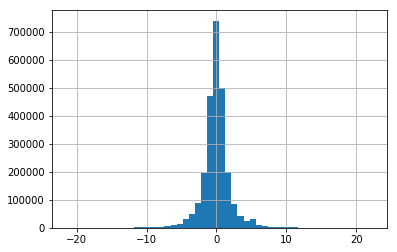

In [86]:
pred_df['lev_l_pred'].hist(bins=50)

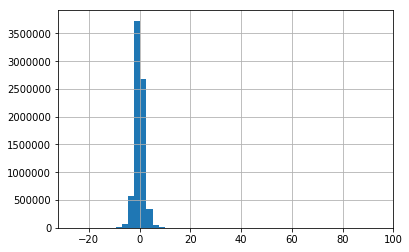

In [87]:
track['lev_l'].hist(bins=50)